## Estimators

In [1]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

def Naive_estimator(rewards, actions, discount_factor):
    discounted_rewards = rewards * (discount_factor ** np.arange(len(rewards)))
    Naive_Est = 2 * np.sum(discounted_rewards * actions) - 2 * np.sum(discounted_rewards * (1 - actions))
    return Naive_Est

def DQ_estimator(rewards, actions, states, discount_factor):
    # calculate the q-values
    def q_function(index, rewards, discount_factor):
        discounted_rewards = rewards[index:] * (discount_factor ** np.arange(len(rewards[index:])))
        return np.sum(discounted_rewards)

    q_values = np.array([q_function(i, rewards, discount_factor) for i in range(len(rewards))])
    discounted_q_values = q_values * (discount_factor ** np.arange(len(rewards)))
    DQ_Est = 2*np.sum(discounted_q_values*actions) - 2*np.sum(discounted_q_values*(1-actions))
    return DQ_Est, q_values

def DQ_truncated_estimator(rewards, actions, states, discount_factor, k):
    def q_function(index, rewards, discount_factor, k):
        end = min(index + k + 1, len(rewards))
        discounted_rewards = rewards[index:end] * (discount_factor ** np.arange(end - index))
        return np.sum(discounted_rewards)

    q_values = np.array([q_function(i, rewards, discount_factor, k) for i in range(len(rewards))])
    discounted_q_values = q_values * (discount_factor ** np.arange(len(rewards)))
    DQ_trunc_Est = 2 * np.sum(discounted_q_values * actions) - 2 * np.sum(discounted_q_values * (1 - actions))
    return DQ_trunc_Est, q_values

In [2]:
import numpy as np
from scipy.linalg import solve

def DQ_dynkin_estimator(rewards, actions, states, discount_factor, k=None, alpha=1.0):
    """
    Dynkin-based value difference estimator using LSTD on-policy path.

    Inputs:
        rewards:     (T,) numpy array
        actions:     (T,) numpy array, values in {0, 1} (0 = control, 1 = treatment)
        states:      (T, d) or (T,) numpy array
        discount_factor: float
        k: unused (for compatibility)
        alpha: regularization parameter

    Returns:
        DQ_dynkin_estimate: float
    """
    # Ensure 2D state input
    states = states.reshape(-1, 1) if states.ndim == 1 else states

    ss = states[:-1]
    snews = states[1:]
    rs = rewards[:-1]

    # Split future state expectations by action
    ss_treated = snews[actions[:-1] == 1]
    ss_control = snews[actions[:-1] == 0]

    delta_xbar = np.mean(ss_treated, axis=0) - np.mean(ss_control, axis=0)
    A = ss.T @ (ss - snews)
    rbar = np.mean(rs)
    b = ss.T @ (rs - rbar)

    lambda_diag = np.ones(A.shape[0])
    theta = solve(A + alpha * np.diag(lambda_diag), b)

    estimate = theta @ delta_xbar
    return estimate, theta


def DQ_LSTD_lambda_estimator(rewards, actions, states, discount_factor, k=None, alpha=1.0, lambda_=0.0):
    """
    LSTD-lambda based estimator of the treatment effect using linear value function approximation,
    with baseline (mean reward) subtraction.

    Inputs:
        rewards:     (T,) numpy array
        actions:     (T,) numpy array, values in {0, 1} (0 = control, 1 = treatment)
        states:      (T, d) or (T,) numpy array
        discount_factor: float in (0,1]
        k: unused (for compatibility)
        alpha: regularization parameter (ridge)
        lambda_: eligibility trace decay parameter in [0, 1]

    Returns:
        (estimate, theta): 
            estimate: float, treatment effect estimate
            theta: (d,) array, linear value function coefficients
    """
    states = states.reshape(-1, 1) if states.ndim == 1 else states
    T, d = states.shape
    phi = states  # feature map: identity

    A = np.zeros((d, d))
    b = np.zeros(d)
    z = np.zeros(d)  # eligibility trace

    r_mean = np.mean(rewards[:-1])  # subtract mean reward from b

    for t in range(T - 1):
        phi_t = phi[t]
        phi_tp1 = phi[t + 1]
        r_t = rewards[t]

        z = lambda_ * discount_factor * z + phi_t  # eligibility trace
        delta_phi = phi_t - discount_factor * phi_tp1
        A += np.outer(z, delta_phi)
        b += z * (r_t - r_mean)  # baseline-subtracted reward

    theta = solve(A + alpha * np.eye(d), b)

    # Estimate treatment effect as value difference between average treated and control future states
    snews = states[1:]
    mask_treat = actions[:-1] == 1
    mask_control = actions[:-1] == 0

    if np.sum(mask_treat) == 0 or np.sum(mask_control) == 0:
        raise ValueError("Insufficient samples for treated or control to compute delta_xbar.")

    ss_treated = snews[mask_treat]
    ss_control = snews[mask_control]
    delta_xbar = np.mean(ss_treated, axis=0) - np.mean(ss_control, axis=0)

    estimate = theta @ delta_xbar
    return estimate, theta



## Nonstationary 2-state MDP

In [3]:
def simulate_nonstationary_mdp(policy, T, transition_kernels, reward_matrix,
                                state_space_size, exo_chain, seed, reward_std=0.1):
    """
    Simulate a non-stationary MDP with stochastic rewards around provided means.
    
    Parameters:
        policy: str in {"treatment", "control", "random"}
        T: time horizon
        transition_kernels: list of transition matrices (len = num_exo_states), shape (S, A, S)
        reward_matrix: mean reward matrix, shape (S, A)
        state_space_size: int, number of MDP states
        exo_chain: np.array shape (T,), states of the exogenous chain (indices)
        seed: int
        reward_std: float, standard deviation of reward noise (default = 0.1)

    Returns:
        rewards, actions, states
    """
    np.random.seed(seed)
    states, actions, rewards = [], [], []
    current_state = np.random.choice(state_space_size)

    for t in range(T):
        z_t = exo_chain[t]
        P = transition_kernels[z_t]

        # Choose action
        if policy == "treatment":
            a_t = 1
        elif policy == "control":
            a_t = 0
        elif policy == "random":
            a_t = np.random.choice([0, 1])

        # Generate reward from Normal(mean, std)
        mean_reward = reward_matrix[current_state, a_t]
        reward = np.random.normal(loc=mean_reward, scale=reward_std)

        rewards.append(reward)
        actions.append(a_t)
        states.append(current_state)

        # Transition to next state
        next_state = np.random.choice(state_space_size, p=P[current_state, a_t])
        current_state = next_state

    return np.array(rewards), np.array(actions), np.array(states)


In [4]:
def generate_exo_chain_identity(T):
    """
    Generate a 'dummy' exogenous chain where the index just tracks time.
    This allows indexing into the time-varying transition kernel.
    """
    return np.arange(T)

def generate_mean_reverting_kernels(
    T,
    mixing_coeff=0.3,         # TV distance between row_0 and row_1 at initialization and long run
    treatment_bias=0.1,       # shifts both rows toward state 1
    smoothness=0.95,          # AR(1) mean-reversion parameter
    noise_std=0.02,           # Gaussian noise
    seed=None
):
    """
    Generates non-stationary 2-state, 2-action kernels with row-wise AR(1) mean reversion
    to fixed means defined by initial row_0 and row_1 with a given mixing coefficient.

    Returns:
        List of kernels of shape (2, 2, 2)
    """
    if seed is not None:
        np.random.seed(seed)

    kernels = []

    def construct_random_rows_with_exact_tv(mixing_coeff):
        """
        Construct two valid 2D probability vectors with exact total variation distance = mixing_coeff.
        
        This version ensures all entries ∈ [0, 1].

        Returns:
            row0, row1: numpy arrays with TV(row0, row1) == mixing_coeff
        """
        assert 0 < mixing_coeff < 1, "mixing_coeff must be in (0, 1)"
        assert mixing_coeff <= 1.0, "mixing_coeff cannot exceed 1.0"

        delta = mixing_coeff / 2

        # Randomly choose which row is skewed toward which state
        if np.random.rand() < 0.5:
            row0 = np.array([0.5 + delta, 0.5 - delta])
            row1 = np.array([0.5 - delta, 0.5 + delta])
        else:
            row0 = np.array([0.5 - delta, 0.5 + delta])
            row1 = np.array([0.5 + delta, 0.5 - delta])

        return row0, row1
    
    row0_mean, row1_mean = construct_random_rows_with_exact_tv(mixing_coeff)

    # Initialize current rows
    row_0 = row0_mean.copy()
    row_1 = row1_mean.copy()

    for t in range(T):
        kernel = np.zeros((2, 2, 2))

        # AR(1) with mean reversion toward initial means
        row_0 = smoothness * row_0 + (1 - smoothness) * row0_mean + np.random.normal(0, noise_std, 2)
        row_1 = smoothness * row_1 + (1 - smoothness) * row1_mean + np.random.normal(0, noise_std, 2)

        # Clip and normalize to keep stochastic
        for row in [row_0, row_1]:
            row[:] = np.clip(row, 0.01, 0.99)
            row[:] /= row.sum()

        # Action 0 (control)
        kernel[0, 0] = row_0.copy()
        kernel[1, 0] = row_1.copy()

        # Action 1 (treatment): shift both rows toward state 1
        for s in [0, 1]:
            biased_row = kernel[s, 0] + np.array([-treatment_bias, treatment_bias])
            biased_row = np.clip(biased_row, 0.01, 0.99)
            kernel[s, 1] = biased_row / biased_row.sum()

        kernels.append(kernel)

    return kernels

In [5]:
from joblib import Parallel, delayed
from tqdm import tqdm

def simulate_single_trial_combined(i, T, transition_kernels, reward_matrix, exo_chain, state_space_size, discount_factor, k_list):
    # Simulate treatment and control for true ATE
    
    r_treat, _, _ = simulate_nonstationary_mdp("treatment", T, transition_kernels, reward_matrix, state_space_size, exo_chain, seed=1000+i)
    r_control, _, _ = simulate_nonstationary_mdp("control", T, transition_kernels, reward_matrix, state_space_size, exo_chain, seed=2000+i)
    true_ate = (np.sum(r_treat) - np.sum(r_control)) / T

    # Simulate random policy for estimators
    r_rand, a_rand, s_rand = simulate_nonstationary_mdp("random", T, transition_kernels, reward_matrix, state_space_size, exo_chain, seed=3000+i)

    stationary_dq, _ = DQ_LSTD_lambda_estimator(r_rand, a_rand, s_rand, discount_factor)

    # Compute DQ-truncated estimators for each k
    dq_trunc_by_k = {}
    for k in k_list:
        dq_trunc, _ = DQ_truncated_estimator(r_rand, a_rand, s_rand, discount_factor, k)
        dq_trunc_by_k[k] = dq_trunc / T

    return true_ate, dq_trunc_by_k, stationary_dq


def evaluate_estimators_truncated_only(n_trials, T, transition_kernels, reward_matrix, exo_chain, state_space_size, discount_factor):
    k_list = [0, 1, 3, 5, 10, 50, 100, 500, T]

    results = Parallel(n_jobs=-1)(
        delayed(simulate_single_trial_combined)(
            i, T, transition_kernels, reward_matrix, exo_chain, state_space_size, discount_factor, k_list
        ) for i in tqdm(range(n_trials), desc="Simulating trials with estimators")
    )

    # Unpack results
    true_ates_all = []
    dq_results_by_k = {k: [] for k in k_list}
    stationary_dqs = []

    for true_ate, dq_trunc_by_k, stationary_dq in results:
        true_ates_all.append(true_ate)
        stationary_dqs.append(stationary_dq)
        for k in k_list:
            dq_results_by_k[k].append(dq_trunc_by_k[k])

    # Combine into results dict
    results_dict = {"Ground Truth ATE": true_ates_all}
    results_dict["Stationary DQ"] = stationary_dqs
    for k in k_list:
        results_dict[f"k={k}"] = dq_results_by_k[k]

    return results_dict


## Numerical simulation plots

In [6]:
import numpy as np
import pickle

# Set up parameter grid
mixing_coeffs = np.round(np.linspace(0.01, 0.99, num=20), 2)  # e.g., [0.3, 0.4, ..., 1.0]
treatment_bias = 0.1  # example
smoothness = 0.5      # example
noise_std = 0.1      # example
T = 5000

reward_matrix = np.array([[0, 1], 
                          [5, 6]])

exo_chain = generate_exo_chain_identity(T)

seed = 42

for mixing_coeff in mixing_coeffs:
    transition_kernels = generate_mean_reverting_kernels(
        T=T,
        mixing_coeff=mixing_coeff,
        treatment_bias=treatment_bias,
        smoothness=smoothness,
        noise_std=noise_std,
        seed=seed
    )

    results = evaluate_estimators_truncated_only(
        n_trials=1000,
        T=T,
        transition_kernels=transition_kernels,
        reward_matrix=reward_matrix,
        exo_chain=exo_chain,
        state_space_size=2,
        discount_factor=1.0
    )

    filename = f"results/results_mix{mixing_coeff:.2f}_bias{treatment_bias}_smooth{smoothness}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    print(f"Results saved to {filename}")


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.04it/s]


Results saved to results/results_mix0.01_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.30it/s]


Results saved to results/results_mix0.06_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.17it/s]


Results saved to results/results_mix0.11_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s]


Results saved to results/results_mix0.16_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.13it/s]


Results saved to results/results_mix0.22_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.47it/s]


Results saved to results/results_mix0.27_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.44it/s]


Results saved to results/results_mix0.32_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.52it/s]


Results saved to results/results_mix0.37_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.47it/s]


Results saved to results/results_mix0.42_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.43it/s]


Results saved to results/results_mix0.47_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.29it/s]


Results saved to results/results_mix0.53_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:46<00:00, 21.50it/s]


Results saved to results/results_mix0.58_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s]


Results saved to results/results_mix0.63_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.17it/s]


Results saved to results/results_mix0.68_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.10it/s]


Results saved to results/results_mix0.73_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s]


Results saved to results/results_mix0.78_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s]


Results saved to results/results_mix0.84_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.11it/s]


Results saved to results/results_mix0.89_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s]


Results saved to results/results_mix0.94_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s]


Results saved to results/results_mix0.99_bias0.1_smooth0.5.pkl


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
sns.set()

def plot_bias_vs_mixing(results_dir, treatment_bias, 
                        k_list=["k=0", "k=1", "k=3", "k=5", "k=10"], 
                        mixing_coeff_list=None, smoothness=0.5):
    
    if mixing_coeff_list is None:
        mixing_coeff_list = np.round(np.linspace(0.3, 1.0, num=8), 2)

    bias_by_k = {k: [] for k in k_list}

    for mixing_coeff in mixing_coeff_list:
        try:
            filename = f"{results_dir}/results_mix{mixing_coeff:.2f}_bias{treatment_bias}_smooth{smoothness}.pkl"
            with open(filename, 'rb') as f:
                results = pickle.load(f)
        except FileNotFoundError:
            print(f"File not found: {filename}")
            continue

        gate_list = np.array(results["Ground Truth ATE"])

        for k in k_list:
            if k not in results:
                print(f"Missing key {k} in {filename}")
                continue
            est_list = np.array(results[k])
            bias_pct = np.abs(100 * (est_list - gate_list) / gate_list)
            bias_mean = np.mean(bias_pct)
            bias_by_k[k].append(bias_mean)

    # Set color palette
    palette = sns.color_palette("Set1", n_colors=len(k_list))

    # Plot all k-lines (in lighter color)
    plt.figure(figsize=(7.5, 5.25))
    for i, k in enumerate(k_list):
        if len(bias_by_k[k]) == len(mixing_coeff_list):
            plt.plot(mixing_coeff_list, bias_by_k[k], 
                     marker='o', label=k, color=palette[i], 
                     linewidth=1.5, alpha=0.65, zorder=1)

    # Construct the lower envelope
    lower_mae = []
    lower_k_idx = []
    for j in range(len(mixing_coeff_list)):
        min_mae = float('inf')
        min_idx = -1
        for i, k in enumerate(k_list):
            if len(bias_by_k[k]) == len(mixing_coeff_list):
                val = bias_by_k[k][j]
                if val < min_mae:
                    min_mae = val
                    min_idx = i
        lower_mae.append(min_mae)
        lower_k_idx.append(min_idx)

    # Plot each segment in the corresponding color of the winning k
    for j in range(len(mixing_coeff_list) - 1):
        x1, x2 = mixing_coeff_list[j], mixing_coeff_list[j+1]
        y1, y2 = lower_mae[j], lower_mae[j+1]
        k_idx = lower_k_idx[j]
        plt.plot([x1, x2], [y1, y2], color=palette[k_idx], linewidth=3.0, zorder=3)

    # Also plot the envelope points
    for j, (x, y) in enumerate(zip(mixing_coeff_list, lower_mae)):
        plt.scatter(x, y, color=palette[lower_k_idx[j]], edgecolor='black', zorder=4, s=50)

    # Labels and formatting
    plt.xlabel(r"Mixing rate $\gamma$", fontsize=20)
    plt.ylabel("MAE (%)", fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Truncation size", fontsize=16, title_fontsize=16, ncol=2, loc='upper left')
    plt.xticks(np.round(np.linspace(0.0, 1.0, num=11), 2), fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

    filename = f"plots/mix_plot.pdf"
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


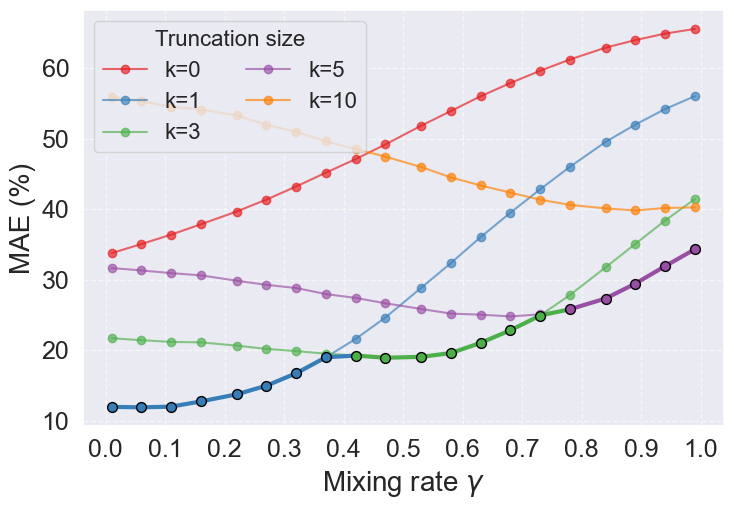

In [8]:
plot_bias_vs_mixing(
    results_dir="results",
    treatment_bias=0.1,  # or 0.1
    k_list=["k=0", "k=1", "k=3", "k=5", "k=10"],
    mixing_coeff_list=mixing_coeffs,
    smoothness=0.5
)


In [9]:
import numpy as np
import pickle
import os

def summarize_across_mixing(results_dir, treatment_bias, 
                             k_list=["k=0", "k=1", "k=3", "k=5", "k=10"],
                             mixing_coeffs=None, smoothness=0.0):
    if mixing_coeffs is None:
        mixing_coeffs = np.round(np.linspace(0.01, 0.99, num=20), 2)

    mae_by_k = {k: [] for k in k_list}
    std_by_k = {k: [] for k in k_list}
    all_ground_truth_values = []

    for mixing_coeff in mixing_coeffs:
        filename = f"{results_dir}/results_mix{mixing_coeff:.2f}_bias{treatment_bias}_smooth{smoothness}.pkl"
        if not os.path.exists(filename):
            print(f"Missing: {filename}")
            continue

        with open(filename, 'rb') as f:
            results = pickle.load(f)

        gate_list = np.array(results["Ground Truth ATE"])
        all_ground_truth_values.append(gate_list)

        for k in k_list:
            if k not in results:
                continue
            est_list = np.array(results[k])
            bias_pct = np.abs(100 * (est_list - gate_list) / gate_list)
            mae_by_k[k].append(np.mean(bias_pct))
            std_by_k[k].append(np.std(est_list))

    # Compute mean ground truth ATE
    if all_ground_truth_values:
        ground_truth_all = np.concatenate(all_ground_truth_values)
        mean_gate = np.mean(ground_truth_all)
        print(f"\nMean Ground Truth ATE across all files: {mean_gate:.4f}")
    else:
        print("No Ground Truth ATEs loaded.")

    # Compute summary stats for each k
    print("\nSummary across mixing coefficients:\n")
    for k in k_list:
        mae_vals = mae_by_k[k]
        std_vals = std_by_k[k]
        if len(mae_vals) > 0:
            mae_mean = np.mean(mae_vals)
            std_mean = np.mean(std_vals)
            print(f"{k}: MAE = {mae_mean:.2f}%, STD = {std_mean:.4f}")
        else:
            print(f"{k}: No data available.")


In [10]:
summarize_across_mixing(
    results_dir="results",
    treatment_bias=0.1,
    k_list=["k=0", "k=1", "k=3", "k=5", "k=10", "k=50", "k=100", "k=5000"],
    smoothness=0.5
)



Mean Ground Truth ATE across all files: 2.1187

Summary across mixing coefficients:

k=0: MAE = 50.34%, STD = 0.1254
k=1: MAE = 29.84%, STD = 0.2415
k=3: MAE = 24.30%, STD = 0.4618
k=5: MAE = 28.47%, STD = 0.6788
k=10: MAE = 47.02%, STD = 1.2026
k=50: MAE = 206.55%, STD = 5.3122
k=100: MAE = 403.15%, STD = 10.4303
k=5000: MAE = 11318.22%, STD = 298.5165


## Appendix plots

In [11]:
import numpy as np
import pickle

# Set up parameter grid
mixing_coeffs = [0.1, 0.3, 0.5, 0.7] 
treatment_bias_list = [0.1, 0.3]  # example
smoothness = 0.5      # example
noise_std = 0.1      # example
T = 5000

reward_matrix = np.array([[0, 1], 
                          [5, 6]])

exo_chain = generate_exo_chain_identity(T)

seed = 42

for mixing_coeff in mixing_coeffs:
    for treatment_bias in treatment_bias_list:
        transition_kernels = generate_mean_reverting_kernels(
            T=T,
            mixing_coeff=mixing_coeff,
            treatment_bias=treatment_bias,
            smoothness=smoothness,
            noise_std=noise_std,
            seed=seed
        )

        results = evaluate_estimators_truncated_only(
            n_trials=1000,
            T=T,
            transition_kernels=transition_kernels,
            reward_matrix=reward_matrix,
            exo_chain=exo_chain,
            state_space_size=2,
            discount_factor=1.0
        )

        filename = f"results/results_mix{mixing_coeff:.1f}_bias{treatment_bias}_smooth{smoothness}.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(results, f)

        print(f"Results saved to {filename}")


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 20.97it/s]


Results saved to results/results_mix0.1_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.07it/s]


Results saved to results/results_mix0.1_bias0.3_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 20.95it/s]


Results saved to results/results_mix0.3_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


Results saved to results/results_mix0.3_bias0.3_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


Results saved to results/results_mix0.5_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 20.98it/s]


Results saved to results/results_mix0.5_bias0.3_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.00it/s]


Results saved to results/results_mix0.7_bias0.1_smooth0.5.pkl


Simulating trials with estimators: 100%|██████████| 1000/1000 [00:47<00:00, 21.01it/s]


Results saved to results/results_mix0.7_bias0.3_smooth0.5.pkl


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()


def plot_estimator_results_box_from_paths(
    data_dict,
    keys_to_plot,
    display_names,
    mixing_coeff=None,
    treatment_bias=None,
    smoothness=None
):
    assert len(keys_to_plot) == len(display_names), "keys_to_plot and display_names must have the same length"

    # Extract data for selected keys
    data = [data_dict[key] for key in keys_to_plot]
    gate_values = data_dict["Ground Truth ATE"]
    mean_ate = np.mean(gate_values)
    

    # Set up plot
    plt.figure(figsize=(5, 6))

    # Create boxplot
    box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)

    # Use seaborn color palette with transparency
    palette = sns.color_palette("Set3", n_colors=len(data))
    for patch, color in zip(box['boxes'], palette):
        patch.set_facecolor((*color, 0.7))

    # Add horizontal lines
    plt.axhline(y=mean_ate, color='red', linestyle='--', linewidth=1.5, label=f"GATE: {mean_ate:.2f}", zorder=10)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, zorder=9)

    # Style
    plt.ylabel("Est. GATE", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.ylim(bottom=mean_ate - 5, top=mean_ate + 5)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(fontsize=20)
    plt.tight_layout()

    filename = f"plots/gate_boxplot_mix{mixing_coeff}_bias{treatment_bias}_smooth{smoothness}.pdf"
    plt.savefig(filename, bbox_inches='tight')
    print(f"Figure saved to: {filename}")

    plt.show()


Loaded: results/results_mix0.1_bias0.1_smooth0.5.pkl
Figure saved to: plots/gate_boxplot_mix0.1_bias0.1_smooth0.5.pdf


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


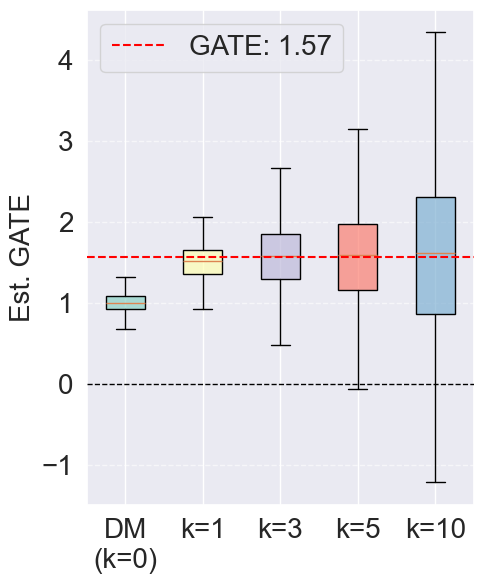

Loaded: results/results_mix0.3_bias0.1_smooth0.5.pkl
Figure saved to: plots/gate_boxplot_mix0.3_bias0.1_smooth0.5.pdf


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


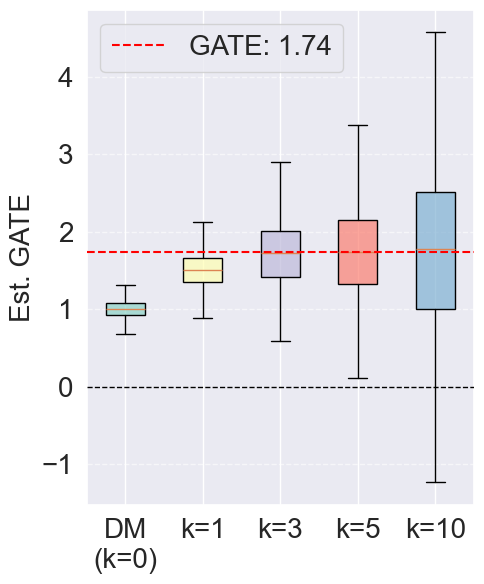

Loaded: results/results_mix0.5_bias0.1_smooth0.5.pkl


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


Figure saved to: plots/gate_boxplot_mix0.5_bias0.1_smooth0.5.pdf


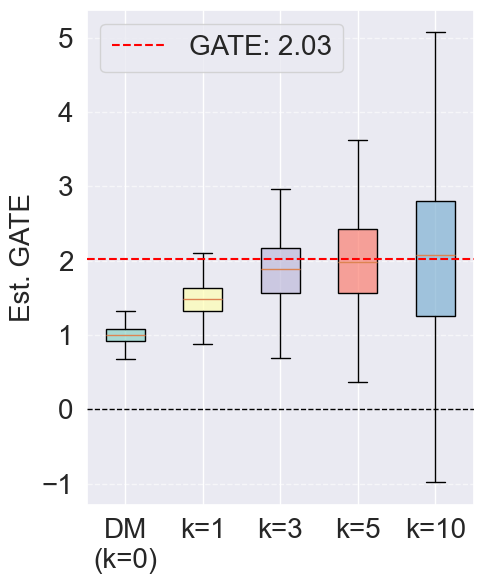

Loaded: results/results_mix0.7_bias0.1_smooth0.5.pkl


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


Figure saved to: plots/gate_boxplot_mix0.7_bias0.1_smooth0.5.pdf


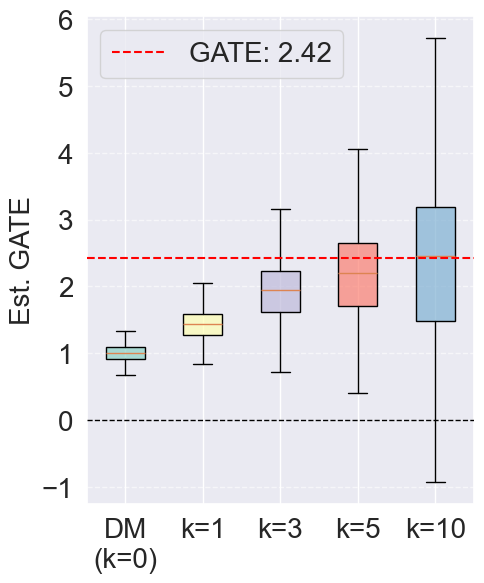

Loaded: results/results_mix0.1_bias0.3_smooth0.5.pkl


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


Figure saved to: plots/gate_boxplot_mix0.1_bias0.3_smooth0.5.pdf


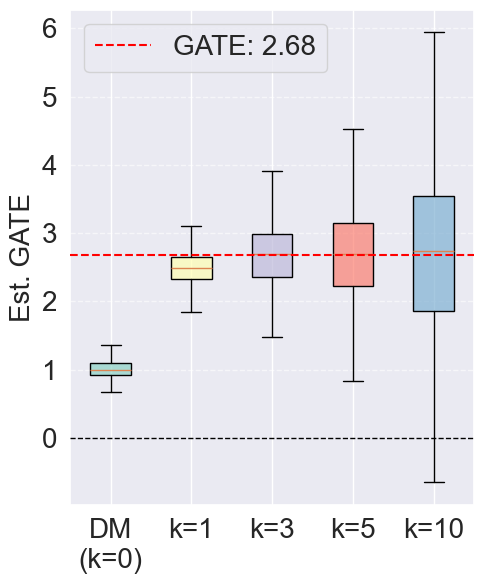

Loaded: results/results_mix0.3_bias0.3_smooth0.5.pkl


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


Figure saved to: plots/gate_boxplot_mix0.3_bias0.3_smooth0.5.pdf


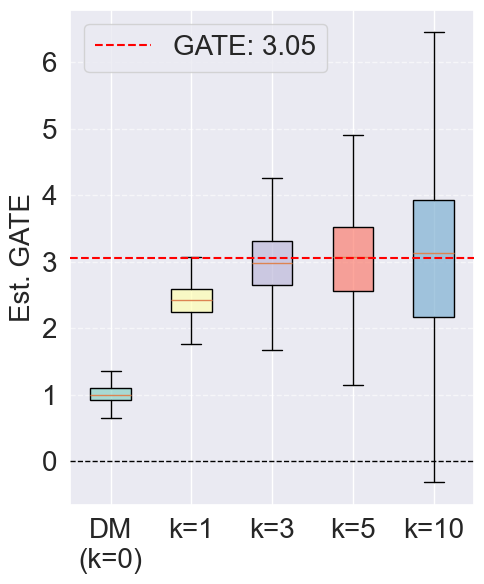

Loaded: results/results_mix0.5_bias0.3_smooth0.5.pkl


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


Figure saved to: plots/gate_boxplot_mix0.5_bias0.3_smooth0.5.pdf


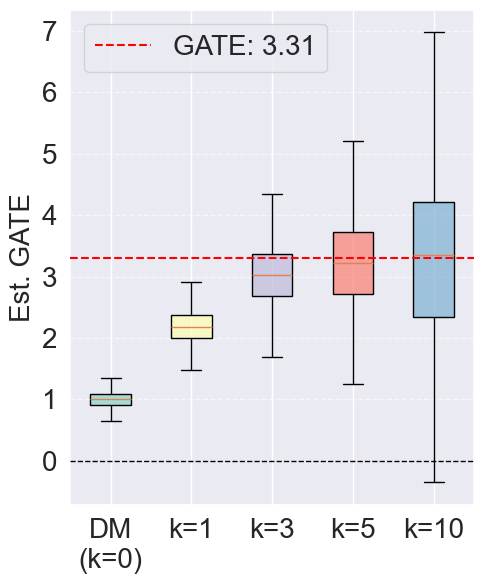

Loaded: results/results_mix0.7_bias0.3_smooth0.5.pkl


/var/folders/l4/c4mz9pzx4wv_v00hmx0kmt3w0000gn/T/ipykernel_36703/3759499599.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, vert=True, patch_artist=True, labels=display_names, showfliers=False)


Figure saved to: plots/gate_boxplot_mix0.7_bias0.3_smooth0.5.pdf


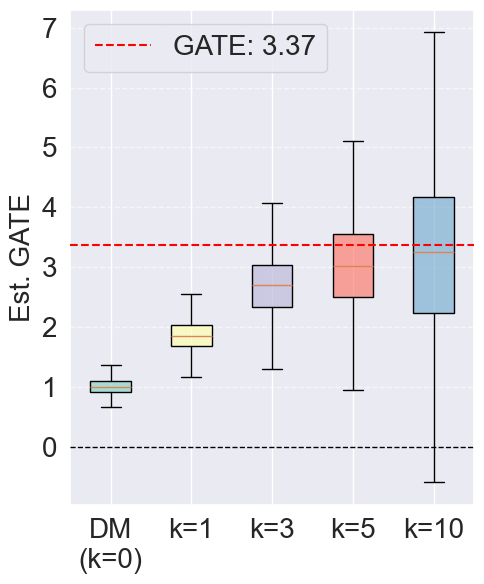

In [13]:
import pickle

mixing_coeff_list = [0.1, 0.3, 0.5, 0.7]
treatment_bias_list = [0.1, 0.3]
smoothness = 0.5

for treatment_bias in treatment_bias_list:
    for mixing_coeff in mixing_coeff_list:
        filename = f"results/results_mix{mixing_coeff}_bias{treatment_bias}_smooth{smoothness}.pkl"

        try:
            with open(filename, 'rb') as f:
                results = pickle.load(f)
            print(f"Loaded: {filename}")

            plot_estimator_results_box_from_paths(
                data_dict=results,
                keys_to_plot=["k=0", "k=1", "k=3", "k=5", "k=10"],
                display_names=["DM\n(k=0)", "k=1", "k=3", "k=5", "k=10"],
                mixing_coeff=mixing_coeff,
                treatment_bias=treatment_bias,
                smoothness=smoothness
            )
        except FileNotFoundError:
            print(f"File not found: {filename}")
